# **Generative Adversarial Networks(GANs)**
<img align='right' width='1000' src="https://cdn-images-1.medium.com/v2/resize:fit:851/0*pPEL7ryJR51VpnDO.jpg">

## **Problems in GANs**

- **Mode collapse**:
<img align='right' width='300' src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/49d4ae5770a264446b799e58b05b77ef842ebb76/1-Figure1-1.png">

 During the training, the generator may collapse to a setting where it always produces same outputs.

 - **two causes of mode collapse in GANs**:

    1. **catastrophic forgetting:**
        Catastrophic forgetting refers to the phenomenon in which a model trained on a specific task forgets the knowledge it has gained while learning a new task.

    2. **discriminator overfitting**
<br>
<br>

- **Vanishing gradient**

<img align='right' width='300' src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_2.53.08_PM.png'>

When the Generated images and Real images distribution are like each other or far from each other the gradient will be close to zero


## **Solution**

**Earth Mover’s distance**:
<img align='right' width='300' src='https://www.researchgate.net/publication/234129934/figure/fig1/AS:643915959005186@1530532936719/d-measures-the-distance-between-two-normal-distributions-of-equal-variance.png'>
Distance between two probability distributions. It can be interpreted as the minimum energy cost of moving and transforming a pile of dirt in the shape of one probability distribution to the shape of the other distribution.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision import transforms

In [ ]:
# Hyperparameters
EPOCH = 20
Z_DIM = 100
LR = 2e-4
BS = 64
C, H, W = 1, 32, 32

loss_func = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Availabe device is: ", device)

Availabe device is:  cuda


In [ ]:
# Visioalize the data
def show(tensor, ch=C, size=(H, W), num_to_display=16):
    """
    Inputs would be tensor with (batch_size, channel, height, weight) dimention
    First we detach() tensor so because it's not require grade any more,
    Then send it to cpu() to make sure the tensor doesn't on different device
    Matplotlib show images in (height, width, channel) dimention so the images permute to match the criteria
    """
    images = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(images[:num_to_display], nrow=4).permute(1, 2, 0)
    plt.axis(False)
    plt.imshow(grid)
    plt.show()

## **work with kaggle**
- First you have to go to your profile and creat API token which will download kaggle.json to your pc
- Now drag and drop json file to your colab files tab
- Run the codes below
    - ```
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets list
    ```
- To download the datasts to your colab open the desire competition(datasets) and click on `three dot` on the upper-right then `copy API command`

-  for more information [click here](https://www.kaggle.com/discussions/general/74235)

In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets download -d "link"

In [ ]:
!unzip 'Path to downloaded file'

In [ ]:
def get_data(data=MNIST, bs=128):
    """
    From torchvision.datasets we can get different dataset
    for training GANs we don't need test datasets just trian sets will be enough
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(H),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.5 for _ in range(C)], [0.5 for _ in range(C)]
        )
    ])
    train_set = MNIST('.',
                      train=True,
                      transform=transform,
                      download=True)

    # group the data in different batch size
    data_loader = DataLoader(train_set, bs, shuffle=True)

    return data_loader

In [ ]:
data = get_data(MNIST, BS)
C, H, W = next(iter(data))[0][0].shape

## **Discriminator and Generator Networkrs**
**DCGAN** stands for Deep Convolutional Generative
Adversarial Network. It is a type of GAN that uses convolutional layers in both the generative and discriminative models.## **Discriminator and Generator Networkrs**

In [ ]:
#Generator
class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, hidden_ch=8, out_ch=C):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self._gen_block(z_dim, hidden_ch*8, 4, 1, 0),
            self._gen_block(hidden_ch*8, hidden_ch*4, 4 , 2 , 1),
            self._gen_block(hidden_ch*4, hidden_ch*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_ch*2, out_ch, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)

    def _gen_block(self, in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

#Discriminator
class Critic(nn.Module):
    def __init__(self, img_ch=1, hidden_ch=8, out_dim=1):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_ch, hidden_ch, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._disc_block(hidden_ch, hidden_ch*2, 4, 2, 1),
            self._disc_block(hidden_ch*2, hidden_ch*4, 4, 2, 1),
            self._disc_block(hidden_ch*4, hidden_ch*8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(hidden_ch * 8 * 2 * 2, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

    def _disc_block(self,in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen_noise = lambda number, z_dim: torch.randn(number, z_dim).to(device)

In [ ]:
gen = Generator().to(device)
gen.apply(weights_init)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
# I we need to change learning rate during training we can use lr_scheduler function in torch.optim
gen_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=2, gamma=0.8)

critic = Critic().to(device)
critic.apply(weights_init)
critic_opt = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.5, 0.999))
critic_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(critic_opt, step_size=2, gamma=0.8)

In [ ]:
#Check the data
x, y = next(iter(data))
print("Shape of dataset images: ", x.shape)
print("label of images", y[:16])

noise = gen_noise(BS, Z_DIM)
fake = gen(noise)
show(x, ch=C, size=(H, W))
show(fake, ch=C, size=(H, W))

## **WLOSS**

**BCELoss**
$$
    \large -\frac{1}{n}\sum_{i=1}^{n}{-[y_i\log(𝚢^{̂}_i) + (1-y_i)\log(1-y^{̂}_i)]}
$$

<br>

$$
\large \text{But in here we will use the mean of the outputs} \\
\large \text{so the gradient of any point won't be zero}
$$

<br>

**Wasserstein Loss**
$$
    \large -\frac{1}{n}\sum_{i=1}^{n}{y_i * 𝚢^{̂}_i}
$$

where the $y^̂$ is the output of the Critic:

**Generator Loss**\
<br>

$$
    \underset{g}{\mathrm{min}} - [\mathbb{E}(C(G(z)))]
$$


$$
   \large 𝒁 ⟶ Generator \xrightarrow[\text{}]{\text{G(z)}} Critic \xrightarrow[\text{}]{\text{C(G(z))}} \overline{C(G(z))}
$$

**Critic Loss**
<br>
**one** matrix to calculate the loss for **real** input and **zeors** matrix to calculate the loss for **fake** input which is the output of generator so the **BCE** formular will be:

<br>

$$
   \large 𝒁 ⟶ Generator \xrightarrow[\text{}]{\text{G(z)}} Criritc \xrightarrow[\text{}]{\text{C(G(z))}} \overline{C(G(z))} \\
   \large 𝐗 ⟶ Criritc \xrightarrow[\text{}]{\text{C(G(z))}} \overline{C(𝐗)} \\
    \underset{d}{\mathrm{min}} - [\mathbb{E}(C(𝐗))) - \mathbb{E}(C(G(z)))]
$$

<br>

**Discriminator** output is between 0 and 1

**Critic** output not restricted to be between 0 and 1

- **MinimaMax game:**

    Critic tries to maximize the the differences, While Generetor tries to minimize the difference

## **Lipschitz continuity**
<img aligh='center' width='300' src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Lipschitz_Visualisierung.gif/640px-Lipschitz_Visualisierung.gif">

The differential of the function need to satisfy $| f^{'} | \leq K$ in every point, meaning it should be K-Lipschitz continuous.

Here $K$ is known as a $K$ Lipschitz constant for function $f(...)$. Functions that are everywhere continuously differentiable is Lipschitz continuous, because the derivative, estimated as $\frac{\lvert f(x_1) - f(x_2) \rvert}{\lvert x_1 - x_2 \rvert}$, has bounds. However, a Lipschitz continuous function may not be everywhere differentiable, such as $f(x) = \lvert x \rvert$.

<br>

**Force the function to be 1-Lipschitz**

$\displaystyle \|W\| $

- **Weight clipping**

    by clipping all entries of W (output of each layer) to within some interval ${\displaystyle [-c,c]}$, we have can bound $ \displaystyle ||W|| $.
    where $\displaystyle ||.||_s $  is the operator norm

- **Gradient penalty**

<br>

$$
   \large LOSS =  - \left( \overline{C(𝐗))} - \overline{C(G(z))} \right) + 𝜆*GP
$$

<br>

$$
    GP = \left( \displaystyle \|∇C(𝐗) \| - 1 \right)^2 \\
    𝐗 = α * 𝐗 + (1 - α) * G(z)
$$

In [ ]:
def gradient_penalty_func(real, fake, critic_net, gamma=10):
    alpha = torch.rand((len(real), 1, 1, 1), requires_grad=True).to(device)
    mix_img = real * alpha + fake * (1 - alpha) # (batch_size, C, H, W)
    score = critic(mix_img) # (batch_size, 1)

    gradient = torch.autograd.grad(
        outputs = score,
        inputs = mix_img,
        grad_outputs=torch.ones_like(score),
        retain_graph=True,
        create_graph=True
    )[0] # -> (batch_size, C, H, W)

    gradient = gradient.view(len(gradient), -1) # (batch_size, -1)
    gradient_norm = gradient.norm(2, dim=1) # get L2 norm on all the output elements
    return gamma * ((gradient_norm - 1) ** 2).mean()

In [ ]:
#This the the most important part of the training
def gen_loss_func(gen_net, critic_net, batch_size, z_dim):
    noise = gen_noise(batch_size, z_dim)
    fake = gen_net(noise)
    pred = critic_net(fake)
    return - pred.mean()


def critic_loss_func(gen_net, critic_net, image, batch_size, z_dim):
    noise = gen_noise(batch_size, z_dim)
    fake = gen_net(noise)
    fake_pred = critic_net(fake.detach())  # detach() the generator output so it won't participate in gen_net learning
    real_pred = critic_net(image)

    gradient_penalty = gradient_penalty_func(image, fake.detach(), critic_net)

    return - (real_pred.mean() - fake_pred.mean()) + gradient_penalty

In [ ]:
from torch.utils.tensorboard import SummaryWriter
!rm -r /content/runs
writer = SummaryWriter("/content/runs")
writer_fake = SummaryWriter("/content/runs/fake")
writer_real = SummaryWriter("/content/runs/real")

In [ ]:
# !kill 5081
%load_ext tensorboard
%tensorboard --logdir=runs
# %reload_ext tensorboard

In [ ]:
!rm -r $PATH
PATH = "/content/model/"
!mkdir $PATH

In [ ]:
gen = Generator().to(device)
gen.load_state_dict(torch.load('/content/Gen_20'))
gen_opt = torch.optim.Adam(gen.parameters(), lr=5e-5, betas=(0.5, 0.999))
gen_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=2, gamma=0.8)

critic = Critic().to(device)
critic.load_state_dict(torch.load('/content/Critic_20'))
critic_opt = torch.optim.Adam(critic.parameters(), lr=5e-5, betas=(0.5, 0.999))
critic_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(critic_opt, step_size=2, gamma=0.8)

In [ ]:
step = 0
for epoch in range(EPOCH):
    criticLoss, genLoss = 0, 0
    print(f"\nEpoch: {epoch + 1}")

    for batch,  (real, _) in enumerate(tqdm(data)):
        real = real.to(device)
        critic_loss = critic_loss_func(gen, critic, real, len(real), Z_DIM)
        critic_opt.zero_grad()
        critic_loss.backward(retain_graph=True) # If False, the graph used to compute the grad will be freed, Actually It isnt necessary
        critic_opt.step()

        gen_loss = gen_loss_func(gen, critic, len(real), Z_DIM)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        criticLoss += critic_loss /len(data)
        genLoss += gen_loss /len(data)
        if batch % 150 == 0 and batch != 0:
            # print(f'  batch: {batch} -- {batch*32} of {len(data.dataset)} sample')
            with torch.no_grad():
                step += 1
                fake = gen(gen_noise(BS, Z_DIM)).view(-1, C, H, W)
                image = real.view(-1, C, H, W)
                real_grid = make_grid(image[:32], normalize=True)
                fake_grid = make_grid(fake[:32], normalize=True)

                writer_fake.add_image(
                    "MNIST fake image", fake_grid, global_step=step
                )
                writer_real.add_image(
                    "MNIST real image", real_grid, global_step=step
                )

        #Tensorboard
        # writer.add_scalar("Loss/Critic", criticLoss, (epoch+1)*batch))
        # writer.add_scalar("Loss/Gen", genLoss, (epoch+1)*batch))
        writer.add_scalars("Loss", {
                    "Critic": critic_loss,
                    "Generator": gen_loss
                }, (epoch+1)*batch)

    print(f'  Critic Loss: {criticLoss:.4f} -- Generator Loss: {genLoss:.4f}')
    gen_exp_lr_scheduler.step()
    critic_exp_lr_scheduler.step()

    #Save model
    torch.save(gen.state_dict(), f"{PATH}Gen_{epoch+1}")
    torch.save(critic.state_dict(), f"{PATH}Critic_{epoch+1}")


    if (epoch + 1) % 2 == 0 and epoch > 0:
        print(f"  >>> Critic Learning Rate: {critic_opt.param_groups[0]['lr']}")
        print(f"  >>> Generator Learning Rate: {gen_opt.param_groups[0]['lr']}")

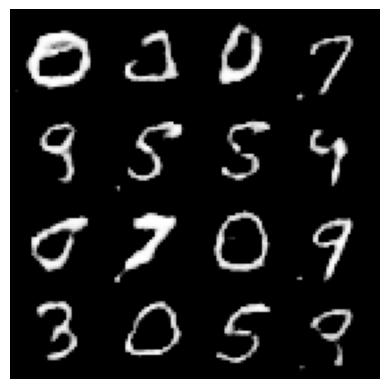

In [ ]:
generated = gen(gen_noise(BS, Z_DIM)).view(-1, C, H, W)
show(generated)

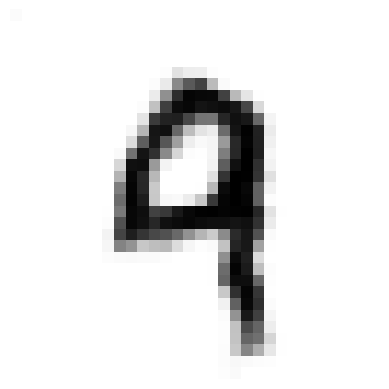

In [ ]:
plt.imshow(generated[1].detach().cpu().permute(1, 2, 0), cmap='gray_r')
plt.axis(False)
plt.show()